# API

In [59]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# %load_ext line_profiler

In [113]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [128]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from pSC import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [127]:
# %%writefile pSC.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib

class Params:
    def __init__(self,
            Lx=4,
            Ly=16,
            Delta=1,
            t=1,
            m=1,
            bcx=-1,
            bcy=1,
            T=0,
            dxmax=16,
            dymax=16,
            history=False,
            ):
        self.Lx = Lx
        self.Ly = Ly
        self.Delta = Delta
        self.t = t
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        if Lx<np.inf and Ly<np.inf:
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron(hopx, np.eye(Ly))
            hopymat = np.kron(np.eye(Lx), hopy)
            onsitemat = np.eye(Lx*Ly)
            self.Hamiltonian = ((np.kron(hopxmat-hopxmat.T, self.sigmay)+np.kron(hopymat-hopymat.T, self.sigmax))* 1j*Delta-t*np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T, self.sigmaz))/2+m*np.kron(onsitemat, self.sigmaz)
        elif Lx==np.inf and Ly==np.inf:
            pass
            # self.dxmax=dxmax
            # self.dymax=dymax
            # self.dx=lambda kx: Delta*np.sin(kx)
            # self.dy=lambda ky: Delta*np.sin(ky)
            # self.dz=lambda kx,ky: m-t*np.cos(kx)-t*np.cos(ky)
        else:
            raise ValueError('The size of system {:d,:d} is not supported.'.format(Lx,Ly))

    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]

    def fermi_dist_k(self,kx,ky,branch,E_F=0):
        pass
        # if self.T==0:
        #     return np.heaviside(E_F-self.E_k(kx,ky,branch),0)
        # else:
        #     return 1/(1+np.exp((self.E_k(kx,ky,branch)-E_F)/self.T))

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))
    
    def correlation_matrix(self, E_F=0):
        '''
        
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f=((occupancy_mat*self.vec)@self.vec.T.conj())
        
    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        # G=self.C_f[::2,::2]
        # F=self.C_f[::2,1::2]
        G=self.C_f[1::2,1::2]
        F=self.C_f[1::2,::2]
        self.G,self.F=G,F
        Gamma_11 = 1j*(F.conj().T+F+G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])+F.conj().T-F-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(F.conj().T+F+G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False):
        '''
        If proj ==True, then the index used for projection operator will be returned
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            linear_index = ((X*self.Ly+Y).flatten('F'))
        else:
            linear_index = ((X*self.dymax+Y).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, 2)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def square_index(self, subregion):
        subregion=np.unique(np.array(subregion)//2)
        if self.Lx<np.inf and self.Ly<np.inf:
            return subregion//self.Ly,subregion%self.Ly
        else:
            return subregion//self.dymax,subregion%self.dymax

    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_f'):
            self.correlation_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        val=np.sort(val)[:val.shape[0]//2]
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)

        return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 2)
        subregion_B = self.linearize_index(subregion_B, 2)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 2)
            subregion_B = self.linearize_index(subregion_B, 2)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB  

    def log_neg(self, subregion_A, subregion_B, Gamma=None,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 2)
            subregion_B = self.linearize_index(subregion_B, 2)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)

    def projection(self, s):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        '''
        assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
        blkmat = np.array([[0, -(-1)**s, 0, 0],
                           [(-1)**s, 0, 0, 0],
                           [0, 0, 0, (-1)**s],
                           [0, 0, -(-1)**s, 0]])
        return blkmat

    def measure(self, s, ix):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(ix[0])
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [ix[0]]

    def measure_all_Born(self, proj_range,prob=None,linear=False):
        if not linear:
            proj_range = self.linearize_index(proj_range, 2, proj=True)
        self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.f_parity= []
        self.covariance_matrix()
        for i in proj_range:
            if prob is None:
                P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
            else:
                P_0=prob
            self.P_0_list.append(P_0)
            if np.random.rand() < P_0:
                self.measure(0, [i, i+1])
                self.f_parity.append(0)
            else:
                self.measure(1, [i, i+1])
                self.f_parity.append(1)
        return self

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

Writing pSC.py


In [115]:
params=Params(m=1,Lx=16,Ly=8,bcx=-1,bcy=1,history=True)

In [93]:
params.covariance_matrix()

In [56]:
np.round(np.real(params.C_f),2)

array([[ 0.03,  0.  ,  0.01, ...,  0.01, -0.  ,  0.02],
       [ 0.  ,  0.97,  0.  , ..., -0.  , -0.02,  0.  ],
       [ 0.01,  0.  ,  0.03, ...,  0.02,  0.  ,  0.01],
       ...,
       [ 0.01, -0.  ,  0.02, ...,  0.97, -0.  , -0.01],
       [-0.  , -0.02,  0.  , ..., -0.  ,  0.03,  0.  ],
       [ 0.02,  0.  ,  0.01, ..., -0.01,  0.  ,  0.97]])

In [47]:
(np.round(np.real(params.G),2))

array([[ 0.75, -0.12, -0.02, -0.12, -0.12, -0.06, -0.02, -0.06,  0.  ,
         0.  , -0.  ,  0.  ,  0.12,  0.06,  0.02,  0.06],
       [-0.12,  0.75, -0.12, -0.02, -0.06, -0.12, -0.06, -0.02,  0.  ,
         0.  ,  0.  ,  0.  ,  0.06,  0.12,  0.06,  0.02],
       [-0.02, -0.12,  0.75, -0.12, -0.02, -0.06, -0.12, -0.06, -0.  ,
        -0.  ,  0.  , -0.  ,  0.02,  0.06,  0.12,  0.06],
       [-0.12, -0.02, -0.12,  0.75, -0.06, -0.02, -0.06, -0.12,  0.  ,
        -0.  , -0.  , -0.  ,  0.06,  0.02,  0.06,  0.12],
       [-0.12, -0.06, -0.02, -0.06,  0.75, -0.12, -0.02, -0.12, -0.12,
        -0.06, -0.02, -0.06,  0.  , -0.  ,  0.  , -0.  ],
       [-0.06, -0.12, -0.06, -0.02, -0.12,  0.75, -0.12, -0.02, -0.06,
        -0.12, -0.06, -0.02, -0.  ,  0.  , -0.  ,  0.  ],
       [-0.02, -0.06, -0.12, -0.06, -0.02, -0.12,  0.75, -0.12, -0.02,
        -0.06, -0.12, -0.06,  0.  , -0.  ,  0.  , -0.  ],
       [-0.06, -0.02, -0.06, -0.12, -0.12, -0.02, -0.12,  0.75, -0.06,
        -0.02, -0.06, -0.1

In [53]:
(np.round(np.real(params.C_m[:4,:4]),2))

array([[ 0.  , -0.93, -0.16,  0.02],
       [ 0.93,  0.  , -0.02,  0.16],
       [ 0.16,  0.02,  0.  , -0.93],
       [-0.02, -0.16,  0.93,  0.  ]])

In [42]:
np.real(params.Hamiltonian)

array([[ 1.,  0., -1.,  0.,  0., -1.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  1.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  1.,  0., -1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  0., -1.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1.,  0.,  1.],
       [ 0.,  0.,  0.,  1., -1.,  0.,  1.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  1.,  0., -1.]])

In [116]:
total=params.linearize_index([np.arange(params.Lx),np.arange(params.Ly)],2)
subA=params.linearize_index([np.arange(params.Lx//4),np.arange(params.Ly)],2)
proj_range=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],2,proj=True)
subB=params.linearize_index([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)],2)


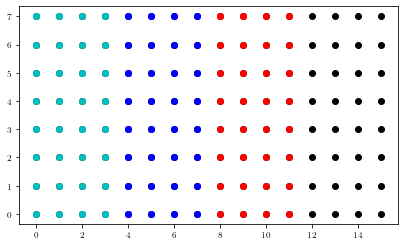

In [117]:
plt.scatter(*params.square_index(total),color='k')
plt.scatter(*params.square_index(subA),color='c')
plt.scatter(*params.square_index(subB),color='r')
plt.scatter(*params.square_index(proj_range),color='b')

In [118]:
params.measure_all_Born(proj_range,linear=True)

In [ ]:
params.i_history

In [120]:
params.log_neg(subA,subB,linear=True)

0.9806550310233653

In [122]:
params.C_m_history[-1][proj_range[0]:proj_range[0]+4,proj_range[0]:proj_range[0]+4]

array([[ 0., -1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.]])

In [121]:
params.s_history

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0]

In [123]:
params.P_0_list

[0.25435944718760717,
 0.23549651344411598,
 0.2331817214050878,
 0.23286980569443305,
 0.23288787763132385,
 0.23295957231993852,
 0.232469440972287,
 0.2103307509205492,
 0.23888214976183308,
 0.32284323145990107,
 0.2755275607263543,
 0.2193968248141817,
 0.21050415398388805,
 0.3433787286210546,
 0.22584578044521492,
 0.20023039512698804,
 0.25346959923359214,
 0.27539507363541404,
 0.2441137671244576,
 0.23523469928944257,
 0.4400875806694614,
 0.1620554403076252,
 0.3873079361263445,
 0.26749247363630246,
 0.228187924997641,
 0.22265845346042268,
 0.21562612814827375,
 0.1895816906182719,
 0.2522869075181625,
 0.40391799348387136,
 0.22963948111407567,
 0.16199630526816222]

In [86]:
m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,20))
# m_list=(np.linspace(1,3,10))
LN_no_list=[]
MI_no_list=[]
for m in m_list:
    params=Params(m=m,Lx=16,Ly=16)
    # MI_no_list.append(params.mutual_information_m(subA,subB,linear=True))
    LN_no_list.append(params.log_neg(subA,subB,linear=True))


Text(0.5, 1.0, 'Finite system')

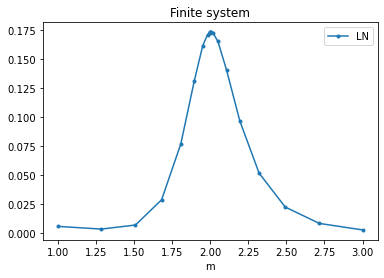

In [87]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list/np.log(2),'.-',label='LN')
# ax.plot(m_list,MI_no_list/np.log(2),'.-',label='MI')
ax.legend()
ax.set_xlabel('m')
ax.set_title('Finite system')

In [134]:
# m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
m_list=(np.linspace(1,3,25))
es=50
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=16,16

def run(p):
    m,Lx,Ly=p
    params=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    total=params.linearize_index([np.arange(params.Lx),np.arange(params.Ly)],2)
    subA=params.linearize_index([np.arange(params.Lx//4),np.arange(params.Ly)],2)
    proj_range=params.linearize_index([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],2,proj=True)
    subB=params.linearize_index([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)],2)

    params.measure_all_Born(proj_range,linear=True)
    LN=params.log_neg(subA,subB,linear=True)
    MI=params.mutual_information_m(subA,subB,linear=True)
    return MI,LN

for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly,bcx=-1,bcy=1)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born(proj_range,linear=True)
    #     MI_Born_list[m_i,es_i]=params.mutual_information_m(subA,subB,linear=True)
    #     LN_Born_list[m_i,es_i]=params.log_neg(subA,subB,linear=True)

    # Parallel
    inputs=[(m,Lx,Ly) for _ in range(es)]
    async_result=rc[:].map_sync(run,inputs)
    for index,results in enumerate(async_result):
        MI_Born_list[m_i,index],LN_Born_list[m_i,index]=results
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_Born_list[m_i,:]=async_result 

    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).mutual_information_m([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # MI_Born_list[m_i,:]=async_result

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:9.7
1:10.2
2:10.2
3:10.1
4:9.1
5:10.1
6:9.8
7:10.5
8:11.6
9:9.2
10:9.0
11:10.6
12:10.6
13:9.4
14:10.2
15:10.3
16:10.2
17:8.9
18:8.8
19:8.9
20:9.1
21:8.8
22:9.0
23:9.3
24:9.8


Text(0.5, 1.0, 'Ensemble Size=50, Lx=16, Ly=16')

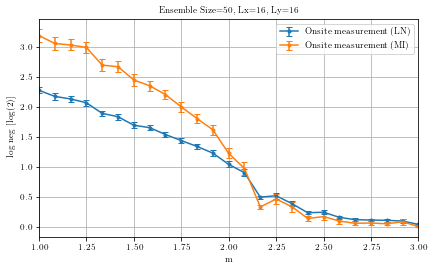

In [136]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
# fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [344]:
# m_list=(lambda x:(x-2)**3+2 )(np.linspace(1,3,10))
m_list=(np.linspace(1,3,10))
es=20
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=16,16
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born(proj_range,prob=1,linear=True)
        # MI_Born_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_Born_list[m_i,es_i]=params.log_neg(subA,subB,linear=True)

    # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_Born_list[m_i,:]=async_result 

    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).mutual_information_m([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # MI_Born_list[m_i,:]=async_result

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:4.5
1:4.5
2:4.6
3:4.6
4:4.6
5:4.5
6:4.5
7:4.6
8:4.6
9:4.5


In [326]:
params=Params(m=1,Lx=16,Ly=16,history=True)

In [327]:
params.covariance_matrix()

In [328]:
np.round(params.C_f[1::2,1::2][:4,:4],5)

array([[ 0.25442+0.j, -0.11675-0.j,  0.00641-0.j, -0.0003 -0.j],
       [-0.11675+0.j,  0.25442+0.j, -0.11675+0.j,  0.00641+0.j],
       [ 0.00641+0.j, -0.11675-0.j,  0.25442+0.j, -0.11675+0.j],
       [-0.0003 +0.j,  0.00641-0.j, -0.11675-0.j,  0.25442+0.j]])

In [329]:
np.round(params.C_m[:4,:4],5)

array([[ 0.     , -0.49117,  0.     ,  0.09949],
       [ 0.49117,  0.     ,  0.56648, -0.     ],
       [-0.     , -0.56648,  0.     , -0.49117],
       [-0.09949,  0.     ,  0.49117,  0.     ]])

In [330]:
params.measure(1,[0,1])

In [331]:
np.round(params.C_m_history[-1][:4,:4],5)

array([[ 0.     , -1.     ,  0.     ,  0.     ],
       [ 1.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , -0.52896],
       [ 0.     ,  0.     ,  0.52896,  0.     ]])

In [332]:
params.C_m[128:132,128:132]

array([[ 0.00000000e+00, -4.91169158e-01, -4.98732999e-17,
         9.94865932e-02],
       [ 4.91169158e-01,  0.00000000e+00,  5.66478153e-01,
        -4.72712147e-17],
       [ 4.98732999e-17, -5.66478153e-01,  0.00000000e+00,
        -4.91169158e-01],
       [-9.94865932e-02,  4.72712147e-17,  4.91169158e-01,
         0.00000000e+00]])

In [333]:
params.measure_all_Born(proj_range,linear=True)

In [334]:
params.C_m_history[-1][128:136,128:136]

array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [121]:
params.C_m_history[0]-params.C_m_history[1]

array([[ 0.00000000e+00, -1.40332999e-05,  9.55510877e-06, ...,
        -2.31595239e-07,  9.12932671e-07, -2.70529264e-06],
       [ 1.40332999e-05,  0.00000000e+00, -6.15784870e-06, ...,
        -3.62788206e-06,  3.23214004e-06,  3.86324930e-06],
       [-9.55510877e-06,  6.15784870e-06,  0.00000000e+00, ...,
         2.57180680e-06, -2.60132336e-06, -1.44335150e-06],
       ...,
       [ 2.31595239e-07,  3.62788206e-06, -2.57180680e-06, ...,
         0.00000000e+00, -1.82670066e-07,  7.63127196e-07],
       [-9.12932671e-07, -3.23214004e-06,  2.60132336e-06, ...,
         1.82670066e-07,  0.00000000e+00, -8.74403829e-07],
       [ 2.70529264e-06, -3.86324930e-06,  1.44335150e-06, ...,
        -7.63127196e-07,  8.74403829e-07,  0.00000000e+00]])

In [105]:
params.von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

4.087646341702329

In [42]:
params.C_f.shape

(128, 128)

In [340]:
np.abs(params.C_m).min()

0.0

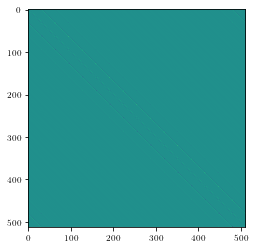

In [343]:
plt.imshow(params.C_m)

In [89]:
np.abs(params.C_m@params.C_m+np.eye(params.C_m.shape[0])).max()

8.881784197001252e-16

In [114]:
params=Params()
params.covariance_matrix()

In [113]:
params.measure_all_Born([np.arange(1,3),np.arange(16)])

In [115]:
np.round(params.C_m[:8,:8],3)

array([[ 0.   ,  0.492, -0.   ,  0.101, -0.   ,  0.033, -0.   ,  0.012],
       [-0.492,  0.   ,  0.573,  0.   ,  0.053,  0.   ,  0.014,  0.   ],
       [ 0.   , -0.573,  0.   ,  0.492, -0.   ,  0.101,  0.   ,  0.033],
       [-0.101, -0.   , -0.492,  0.   ,  0.573,  0.   ,  0.053, -0.   ],
       [ 0.   , -0.053,  0.   , -0.573,  0.   ,  0.492,  0.   ,  0.101],
       [-0.033, -0.   , -0.101, -0.   , -0.492,  0.   ,  0.573, -0.   ],
       [ 0.   , -0.014, -0.   , -0.053, -0.   , -0.573,  0.   ,  0.492],
       [-0.012, -0.   , -0.033,  0.   , -0.101,  0.   , -0.492,  0.   ]])

In [111]:
params.proj_range

[32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94]

In [106]:
np.round(params.C_m[:4,:4],3)

array([[ 0.   ,  0.866,  0.   ,  0.183],
       [-0.866,  0.   ,  0.283, -0.   ],
       [-0.   , -0.283,  0.   ,  0.866],
       [-0.183,  0.   , -0.866,  0.   ]])